## Practice Exam

```
Scoring:
============
 0-11: fail (1),
12-14: pass (2),
15-17: satisfactory (3),
18-20: good (4),
21-24: excellent (5).
```

The file [forestfires.txt](../_data/forestfires.txt) contains data about forest fires in Portugal. Write a program that estimates the value of the *area* feature from the other features! Apply 5-fold cross-validation! The error metric should be the root mean squared error (RMSE).

Subproblems:<br>
**(a)** Perform initial data analysis! Prepare the input matrix $X$ and the target vector $y$! [4 points]<br>
**(b)** Create a t-SNE based visualization of the input features! [4 points]<br>
**(c)** Introduce at least one new feature that is a engineered from the original ones. [4 points]<br>
**(d)** Create a non-tree based estimator and optimize its hyper-parameters! [6 points]<br>
**(e)** Create a tree based estimator and optimize its hyper-parameters! [6 points]<br>

### (a) Perform initial data analysis! Prepare the input matrix 𝑋 and the target vector 𝑦! [4 points]

In [5]:
# Read data from CSV file.
import pandas as pd
fname = 'forestfires.txt'
df = pd.read_csv(fname)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


- there are no null values
- month and day are strings

In [7]:
# columns stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


- standard deviations are quite different
- max(area) is much bigger than the 75-percentile.

<AxesSubplot: >

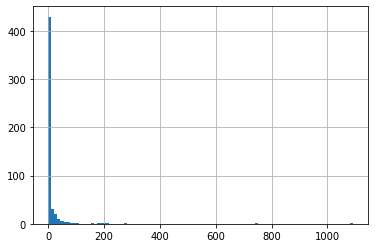

In [15]:
# histogram of area
df['area'].hist(bins=100)

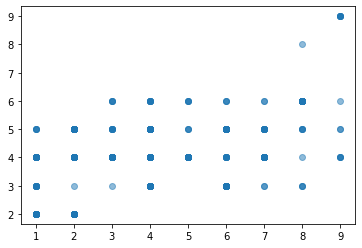

In [19]:
# scatter plot of (X, Y)
import matplotlib.pyplot as plt
plt.scatter(df['X'], df['Y'], alpha=0.5)

In [21]:
# possible values of month
df['month'].unique(), df['month'].nunique()

(array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
        'dec', 'may', 'nov'], dtype=object),
 12)

In [22]:
# possible values of day
df['day'].unique(), df['day'].nunique()

(array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object), 7)

In [28]:
columns = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
X = df[columns].values # input matrix
y = df['area'].values  # target vector

In [32]:
X.shape, y.shape, X.mean(), y.mean()

((517, 10), (517,), 83.46644100580271, 12.847292069632493)

In [35]:
from sklearn.preprocessing import StandardScaler
X2 = StandardScaler().fit_transform(X) # standardize input matrix

### (b) Create a t-SNE based visualization of the input features! [4 points]

In [39]:
from sklearn.manifold import TSNE
Z = TSNE(random_state=42).fit_transform(X2)

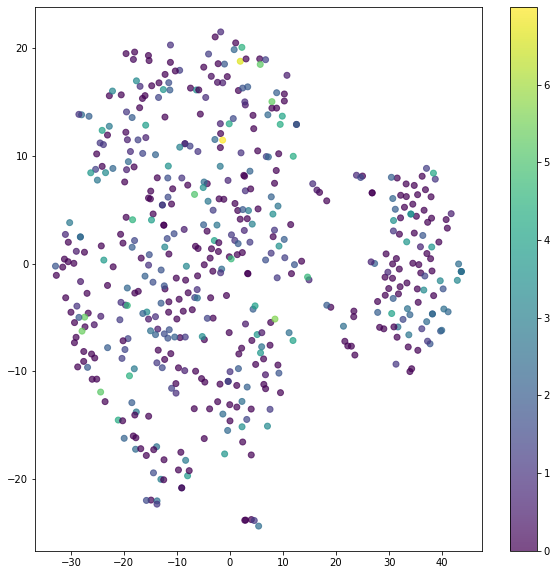

In [51]:
import numpy as np
plt.figure(figsize=(10, 10))
plt.scatter(Z[:, 0], Z[:, 1], c=np.log(y + 1), alpha=0.7)
plt.colorbar()

### (c) Introduce at least one new feature that is a engineered from the original ones. [4 points]

In [58]:
# convert month name to month index
month_idxs = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
}
df['month_idx'] = [month_idxs[m] for m in df['month']]

In [63]:
# convert weekday name to weekday index
day_idxs = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6,'sun': 7
}
df['day_idx'] = [day_idxs[d] for d in df['day']]

### (d) Create a non-tree based estimator and optimize its hyper-parameters! [6 points]

In [78]:
# Ridge regression with default parameters.
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def evaluate(re, X, y):
    cv = KFold(shuffle=True, random_state=42)
    scores = []
    for tr, te in cv.split(X):
        re.fit(X[tr], y[tr])
        yhat = re.predict(X)
        rmse = mean_squared_error(y[te], yhat[te])**0.5
        scores.append(rmse)
    return np.mean(scores)
        
X3 = StandardScaler().fit_transform(df[columns + ['month_idx', 'day_idx']].values)
evaluate(Ridge(), X3, y)

54.58729606435613

<AxesSubplot: xlabel='alpha'>

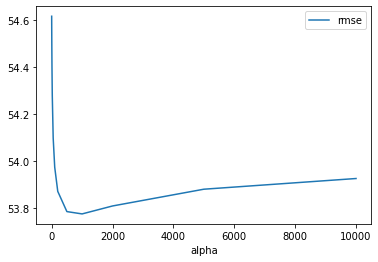

In [88]:
# Hyperparameter optimization.
alphas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
res = []
for alpha in alphas:
    res.append({
        'alpha': alpha,
        'rmse': evaluate(Ridge(alpha=alpha), X3, y)
    })
df_res = pd.DataFrame(res).set_index('alpha')
df_res.plot()

In [91]:
df_res['rmse'].idxmin(), df_res['rmse'].min()

(1000.0, 53.77504142548006)

### (e) Create a tree based estimator and optimize its hyper-parameters! [6 points]

In [95]:
from sklearn.ensemble import GradientBoostingRegressor

evaluate(GradientBoostingRegressor(random_state=42), X3, y)

65.06556168485034

<AxesSubplot: xlabel='max_depth'>

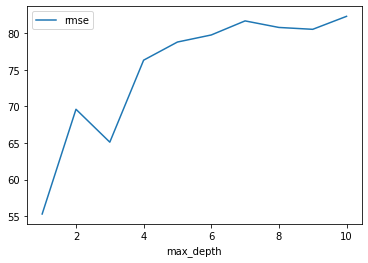

In [96]:
# Hyperparameter optimization.
res = []
for max_depth in range(1, 11):
    print(max_depth, end=' ')
    res.append({
        'max_depth': max_depth,
        'rmse': evaluate(GradientBoostingRegressor(max_depth=max_depth), X3, y)
    })
df_res = pd.DataFrame(res).set_index('max_depth')
df_res.plot()

In [97]:
df_res['rmse'].idxmin(), df_res['rmse'].min()

(1, 55.321957821450226)